
# Supernovae distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus:

$$\mu = m - M = 5\text{log}_{10}\left(\frac{d_L}{pc}\right) - 5$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored.

These are some (synthetic but realistic; see textbook) supernova data:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression, BasisFunctionRegression, NadarayaWatson
from sklearn.model_selection import GridSearchCV, KFold

np.random.seed(123)

C:\Users\lilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


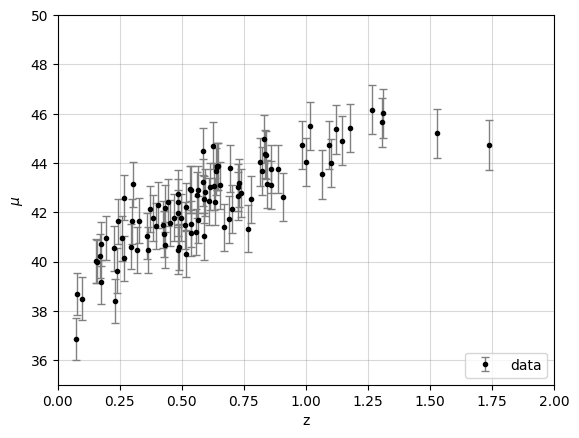

In [2]:
N = 100     # Number of samples to generate
z_sample, mu_sample, dmu = generate_mu_z(N, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()


### Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

## Linear regression

[39.56505555] [[4.64711848]]


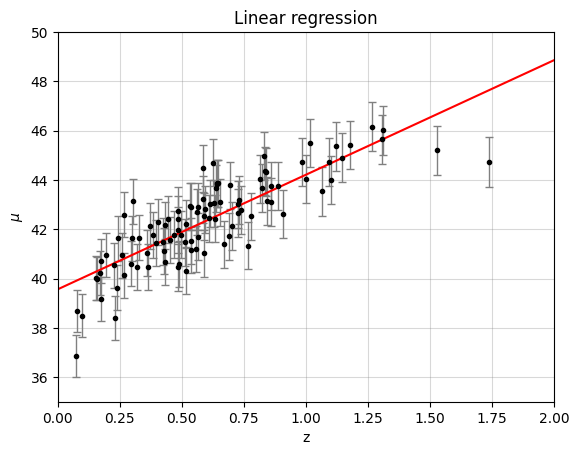

In [3]:
z = z_sample[:, np.newaxis]     # z_sample for plotting, z for fitting
mu = mu_sample[:, np.newaxis]

lin_reg = LinearRegression()
lin_reg.fit(z, mu, sample_weight=1)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

xgrid = np.linspace(0, 2.0, 10)
Y_pred = theta0 + theta1 * xgrid

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1)
plt.plot(xgrid, Y_pred[0], c = 'red')
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.grid(alpha=0.3, c='gray')
plt.title('Linear regression')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Polynomial regression

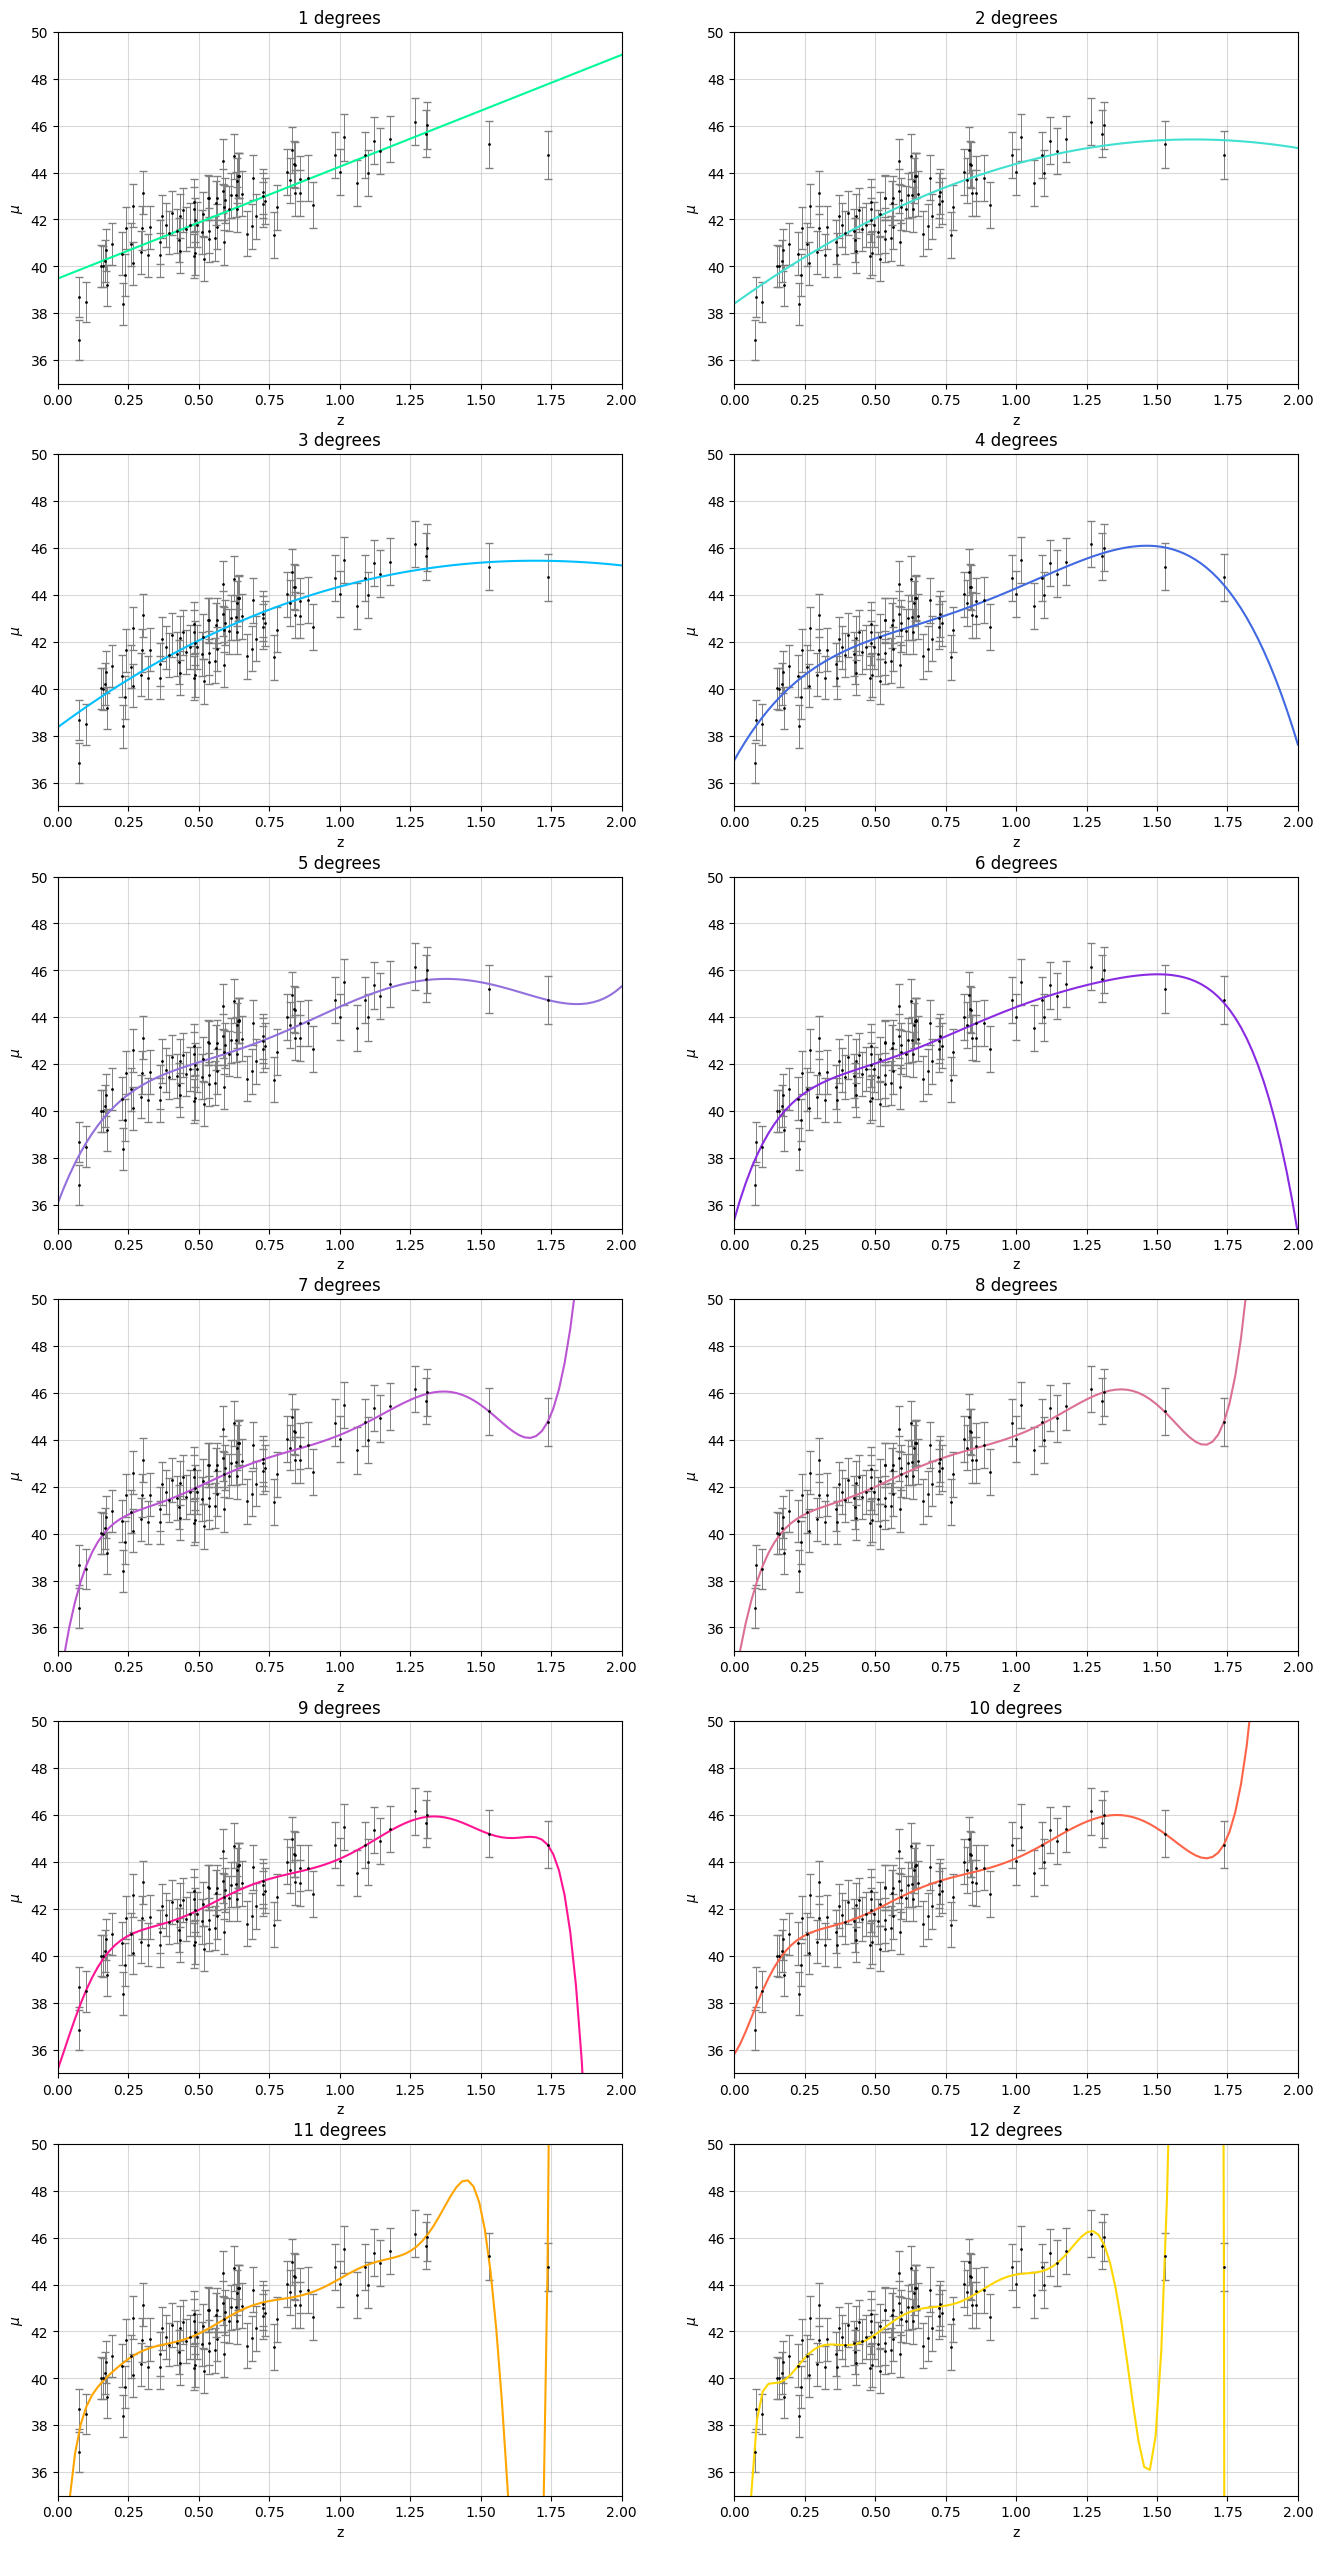

In [4]:
X_points = np.linspace(0, 2.0, 100)
xgrid = X_points[:, np.newaxis]

fig = plt.figure(figsize=(16, 32))

colors = ['mediumspringgreen', 'turquoise', 'deepskyblue', 'royalblue', 'mediumpurple', 'blueviolet', 'mediumorchid', 'palevioletred', 'deeppink', 'tomato', 'orange', 'gold']
degrees = np.arange(1, 13)

for i, degree in enumerate(degrees):
    ax = fig.add_subplot(6,2,1+i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)
    
    model = PolynomialRegression(degree)
    model.fit(z, mu_sample, dmu)     # z.shape = (100, 1), mu.shape = (100, 1), PolynomialRegression wants the y to be (100, ) ---> using mu_sample
    y_poly = model.predict(xgrid)
    
    plt.plot(xgrid, y_poly, lw = 1.5, color = colors[i])
    plt.xlabel('z')
    plt.ylabel('$\\mu$')
    plt.grid(alpha=0.3, c='gray')
    plt.title('%i degrees' % degree)
    plt.xlim(0,2)
    plt.ylim(35,50)
    
plt.show()

Judging by these plots, the linear fit seems to be underfitting the data, while over 7 degrees the polynomials clearly overfit the data. Out of all of them, the $2-$ and $3-$degrees polynomials seem to be the best fits for the data. The $4-$degrees one captures well the last points, but they can be outliers: if that's the case, any other point after them will be poorly predicted.

Let's see what is the best fit according to cross validation:

### Cross validation

Since the computational cost still allows it, I'm gonna use a leave-one-out cross-validation:

Degree: 1 - Train: 0.9865 - Test: 0.7813
Degree: 2 - Train: 0.9038 - Test: 0.7471
Degree: 3 - Train: 0.9039 - Test: 0.7708
Degree: 4 - Train: 0.8712 - Test: 0.7563
Degree: 5 - Train: 0.8648 - Test: 0.7270
Degree: 6 - Train: 0.8625 - Test: 0.9321
Degree: 7 - Train: 0.8493 - Test: 0.7370
Degree: 8 - Train: 0.8491 - Test: 1.0853
Degree: 9 - Train: 0.8482 - Test: 1.1883
Degree: 10 - Train: 0.8481 - Test: 2.4019
Degree: 11 - Train: 0.8456 - Test: 52.1954
Degree: 12 - Train: 0.8296 - Test: 12.1110
Degree: 13 - Train: 0.8281 - Test: 425.4799
Degree: 14 - Train: 0.8143 - Test: 309.7248
Degree: 15 - Train: 0.8139 - Test: 1317.3468
Degree: 16 - Train: 0.8121 - Test: 7042.4237

The best model is the one with 5 degrees



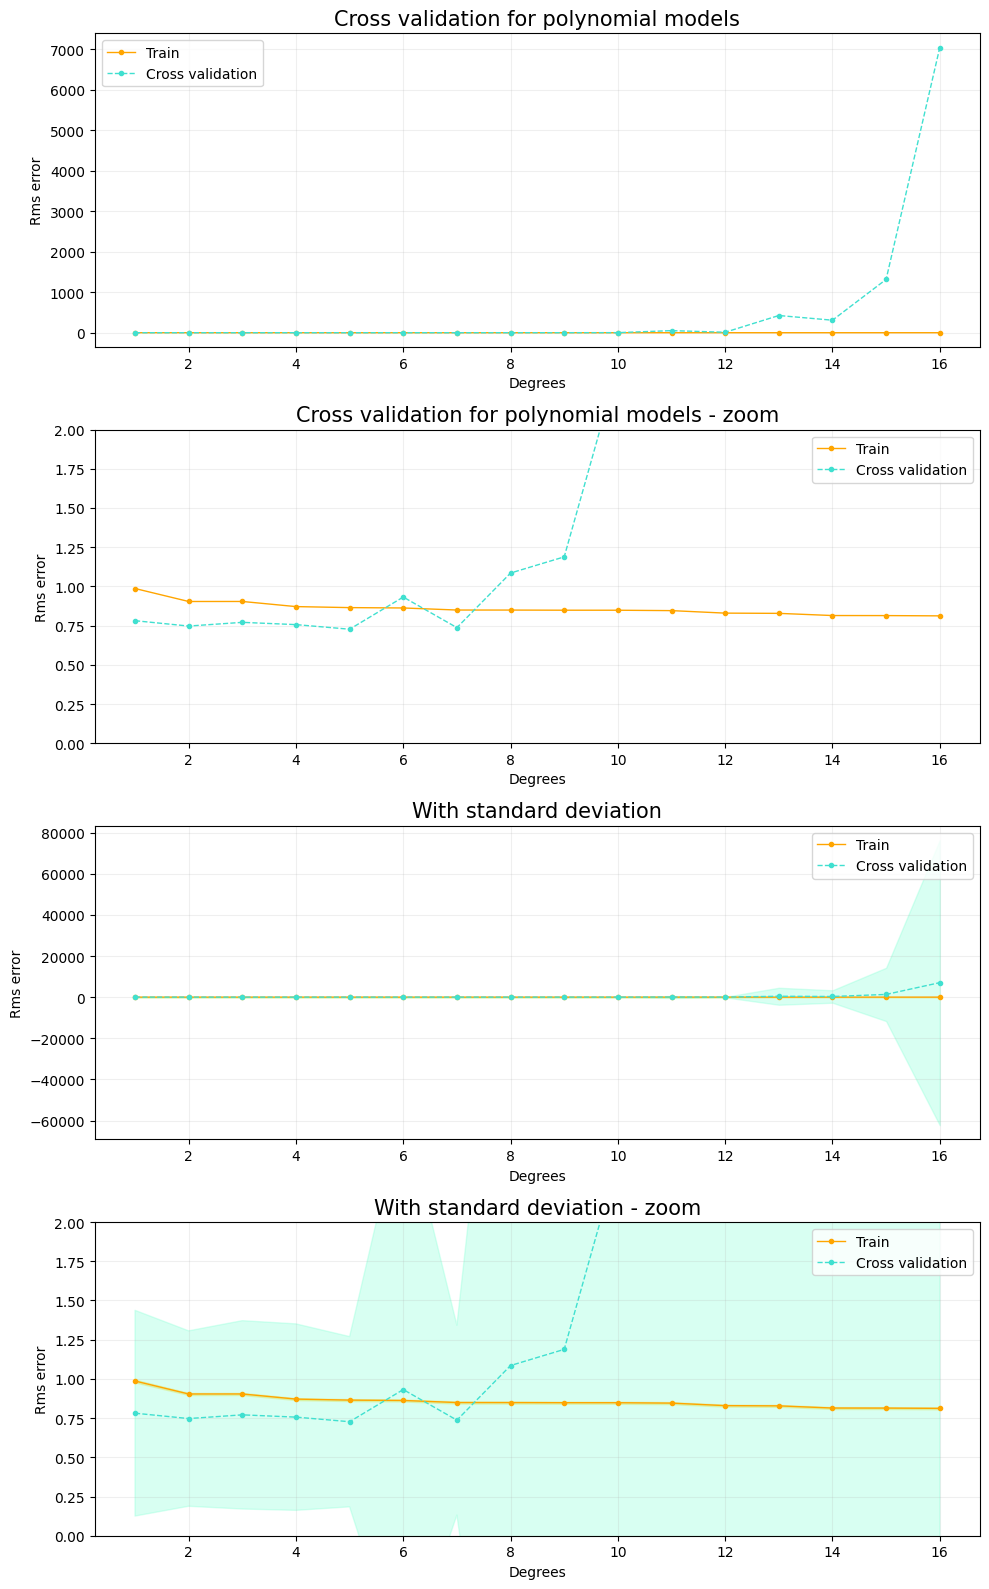

In [22]:
n_splits = 100
degrees = np.arange(1, 17)

rms_train_tot = np.empty(len(degrees))
rms_test_tot = np.empty(len(degrees))

# For the standard deviation
rms_train_tot_std = np.empty(len(degrees))
rms_test_tot_std = np.empty(len(degrees))

for j, degree in enumerate(degrees):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)     # Splitting the data in train and test
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
        z_train, z_test = z[train_index], z[test_index]
        mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
        dmu_train, dmu_test = dmu[train_index], dmu[test_index]
    
        model = PolynomialRegression(degree)
        model.fit(z_train, mu_train, dmu_train)
        
        # Remember, I want to evaluate the rms both on the training data and the test data!
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))
    
    print('Degree: %i - Train: %.4f - Test: %.4f' % (degree, np.mean(rms_train), np.mean(rms_test)))
    rms_train_tot[j] = np.mean(rms_train)
    rms_test_tot[j] = np.mean(rms_test)

    rms_train_tot_std[j] = np.std(rms_train)
    rms_test_tot_std[j] = np.std(rms_test)

d_best = degrees[np.argmin(rms_test_tot)]
print('\nThe best model is the one with %i degrees\n' % d_best)

fig, ax = plt.subplots(4, 1, figsize=(10, 16))

ax[0].plot(degrees, rms_train_tot, lw = 1, color = 'orange', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[0].plot(degrees, rms_test_tot, lw = 1, color = 'turquoise', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[0].set_xlabel('Degrees')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Cross validation for polynomial models', fontsize = 15)
ax[0].grid(alpha = 0.2)
ax[0].legend()

ax[1].plot(degrees, rms_train_tot, lw = 1, color = 'orange', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[1].plot(degrees, rms_test_tot, lw = 1, color = 'turquoise', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[1].set_xlabel('Degrees')
ax[1].set_ylabel('Rms error')
ax[1].set_ylim(0, 2)
ax[1].set_title('Cross validation for polynomial models - zoom', fontsize = 15)
ax[1].grid(alpha = 0.2)
ax[1].legend()

ax[2].plot(degrees, rms_train_tot, lw = 1, color = 'orange', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[2].plot(degrees, rms_test_tot, lw = 1, color = 'turquoise', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[2].fill_between(degrees, rms_train_tot - rms_train_tot_std, rms_train_tot + rms_train_tot_std, color='gold', alpha=0.3)
ax[2].fill_between(degrees, rms_test_tot - rms_test_tot_std, rms_test_tot + rms_test_tot_std, color='aquamarine', alpha=0.3)
ax[2].set_xlabel('Degrees')
ax[2].set_ylabel('Rms error')
ax[2].set_title('With standard deviation', fontsize = 15)
ax[2].grid(alpha = 0.2)
ax[2].legend()

ax[3].plot(degrees, rms_train_tot, lw = 1, color = 'orange', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[3].plot(degrees, rms_test_tot, lw = 1, color = 'turquoise', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[3].fill_between(degrees, rms_train_tot - rms_train_tot_std, rms_train_tot + rms_train_tot_std, color='gold', alpha=0.3)
ax[3].fill_between(degrees, rms_test_tot - rms_test_tot_std, rms_test_tot + rms_test_tot_std, color='aquamarine', alpha=0.3)
ax[3].set_xlabel('Degrees')
ax[3].set_ylabel('Rms error')
ax[3].set_ylim(0, 2)
ax[3].set_title('With standard deviation - zoom', fontsize = 15)
ax[3].grid(alpha = 0.2)
ax[3].legend()

plt.tight_layout(w_pad=2.5)
plt.show()

We can now plot the learning curve:

In [23]:
dataset_size = np.array(np.arange(5, 101, 5))
np.random.seed(123)

rms_train_lc = np.empty(len(dataset_size))
rms_test_lc= np.empty(len(dataset_size)) 

rms_train_lc_std = np.empty(len(dataset_size))
rms_test_lc_std = np.empty(len(dataset_size))

for index, ds in enumerate(dataset_size):
    
    # Choosing randomly the n = ds indexes for the data:
    data_indexes = np.random.choice(np.arange(0, 100), size=ds, replace=False)
    z_lc = z[data_indexes]
    mu_sample_lc = mu_sample[data_indexes]
    dmu_lc = dmu[data_indexes]
    
    n_splits = ds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=None) 
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z_lc), np.arange(n_splits)):
        
        z_train, z_test = z_lc[train_index], z_lc[test_index]
        mu_train, mu_test = mu_sample_lc[train_index], mu_sample_lc[test_index]
        dmu_train, dmu_test = dmu_lc[train_index], dmu_lc[test_index]
        
        model = PolynomialRegression(d_best)
        model.fit(z_train, mu_train, dmu_train)
    
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))

    rms_train_lc[index] = np.mean(rms_train)
    rms_test_lc[index] = np.mean(rms_test)

    rms_train_lc_std[index] = np.std(rms_train)
    rms_test_lc_std[index] = np.std(rms_test)

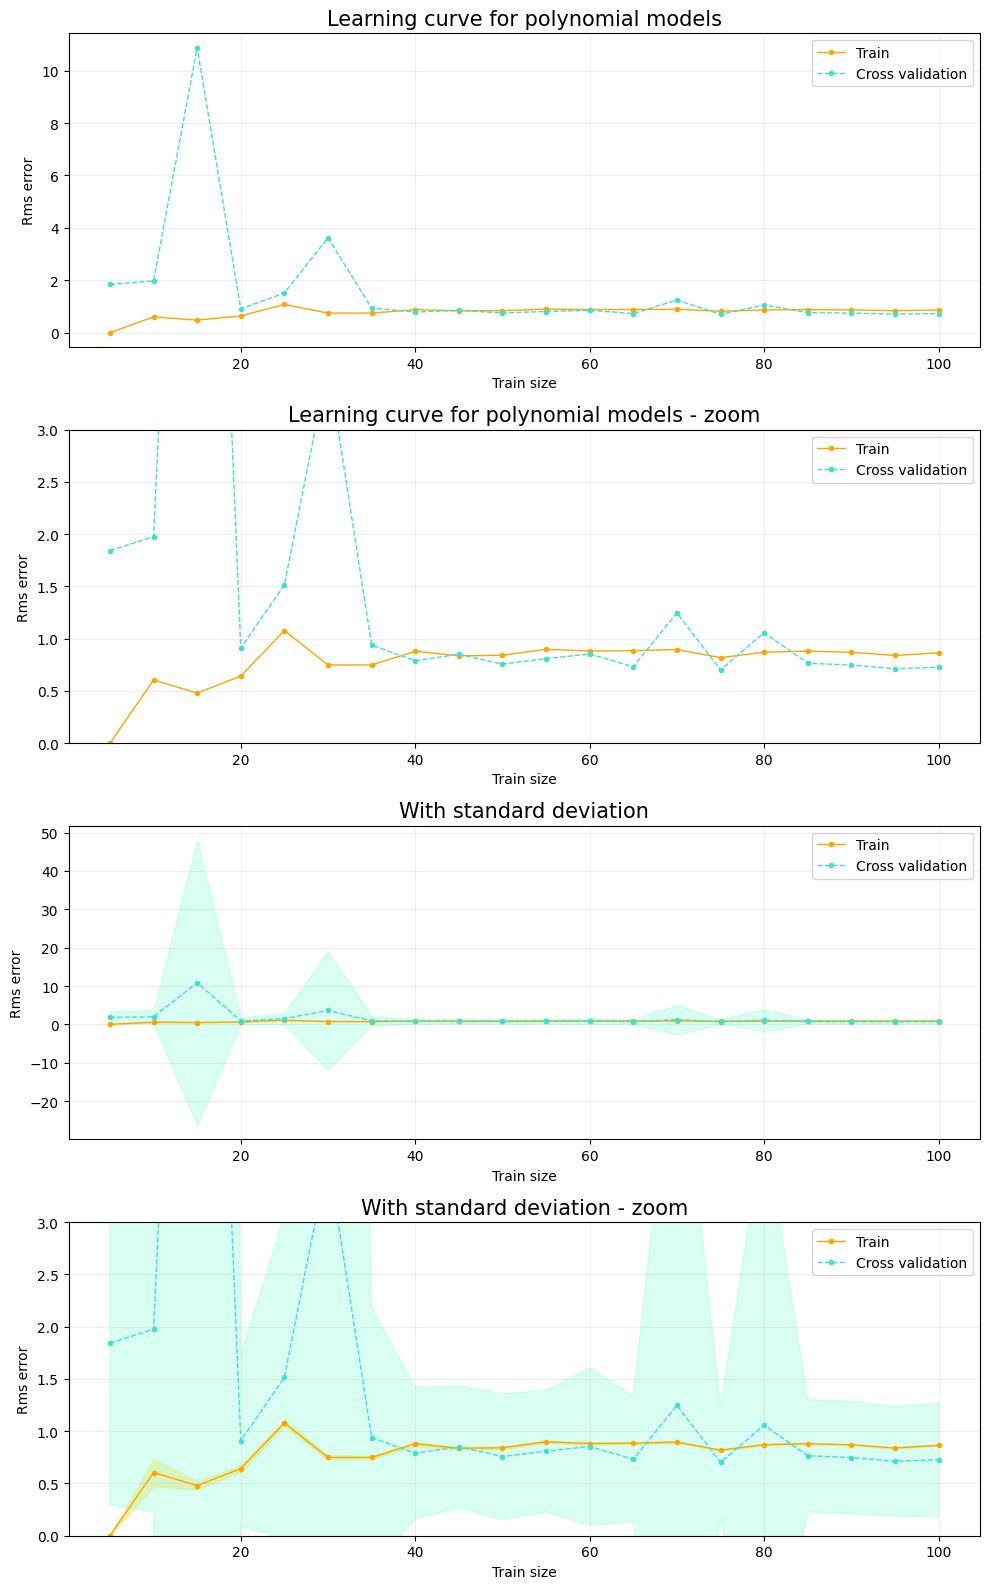

In [27]:
fig, ax = plt.subplots(4, 1, figsize=(10, 16))

ax[0].plot(dataset_size, rms_train_lc, lw = 1, color = 'orange', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[0].plot(dataset_size, rms_test_lc, lw = 1, color = 'turquoise', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[0].set_xlabel('Train size')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Learning curve for polynomial models', fontsize = 15)
ax[0].grid(alpha = 0.2)
ax[0].legend()

ax[1].plot(dataset_size, rms_train_lc, lw = 1, color = 'orange', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[1].plot(dataset_size, rms_test_lc, lw = 1, color = 'turquoise', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[1].set_xlabel('Train size')
ax[1].set_ylabel('Rms error')
ax[1].set_ylim(0, 3)
ax[1].set_title('Learning curve for polynomial models - zoom', fontsize = 15)
ax[1].grid(alpha = 0.2)
ax[1].legend()

ax[2].plot(dataset_size, rms_train_lc, lw = 1, color = 'orange', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[2].plot(dataset_size, rms_test_lc, lw = 1, color = 'turquoise', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[2].fill_between(dataset_size, rms_train_lc - rms_train_lc_std, rms_train_lc + rms_train_lc_std, color='gold', alpha=0.3)
ax[2].fill_between(dataset_size, rms_test_lc - rms_test_lc_std, rms_test_lc + rms_test_lc_std, color='aquamarine', alpha=0.3)
ax[2].set_xlabel('Train size')
ax[2].set_ylabel('Rms error')
ax[2].set_title('With standard deviation', fontsize = 15)
ax[2].grid(alpha = 0.2)
ax[2].legend()

ax[3].plot(dataset_size, rms_train_lc, lw = 1, color = 'orange', ls = '-', marker = 'o', markersize = 3, label = 'Train')
ax[3].plot(dataset_size, rms_test_lc, lw = 1, color = 'turquoise', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
ax[3].fill_between(dataset_size, rms_train_lc - rms_train_lc_std, rms_train_lc + rms_train_lc_std, color='gold', alpha=0.3)
ax[3].fill_between(dataset_size, rms_test_lc - rms_test_lc_std, rms_test_lc + rms_test_lc_std, color='aquamarine', alpha=0.3)
ax[3].set_xlabel('Train size')
ax[3].set_ylabel('Rms error')
ax[3].set_ylim(0, 3)
ax[3].set_title('With standard deviation - zoom', fontsize = 15)
ax[3].grid(alpha = 0.2)
ax[3].legend()

plt.tight_layout(w_pad=2.5)
plt.show()

So, it looks that a dataset of $\sim40$ points is sufficient, and thus we don't need more data to improve the model fitting (though, to be sure, I'd maybe use more than $80$ points to account the fluctuations that happen with that dataset size).

## Basis function regression

Let's try now with basis function regression, using Gaussian functions as a basis. We can first try with a fixed sigma value, cross-validating to find the best number of gaussians:

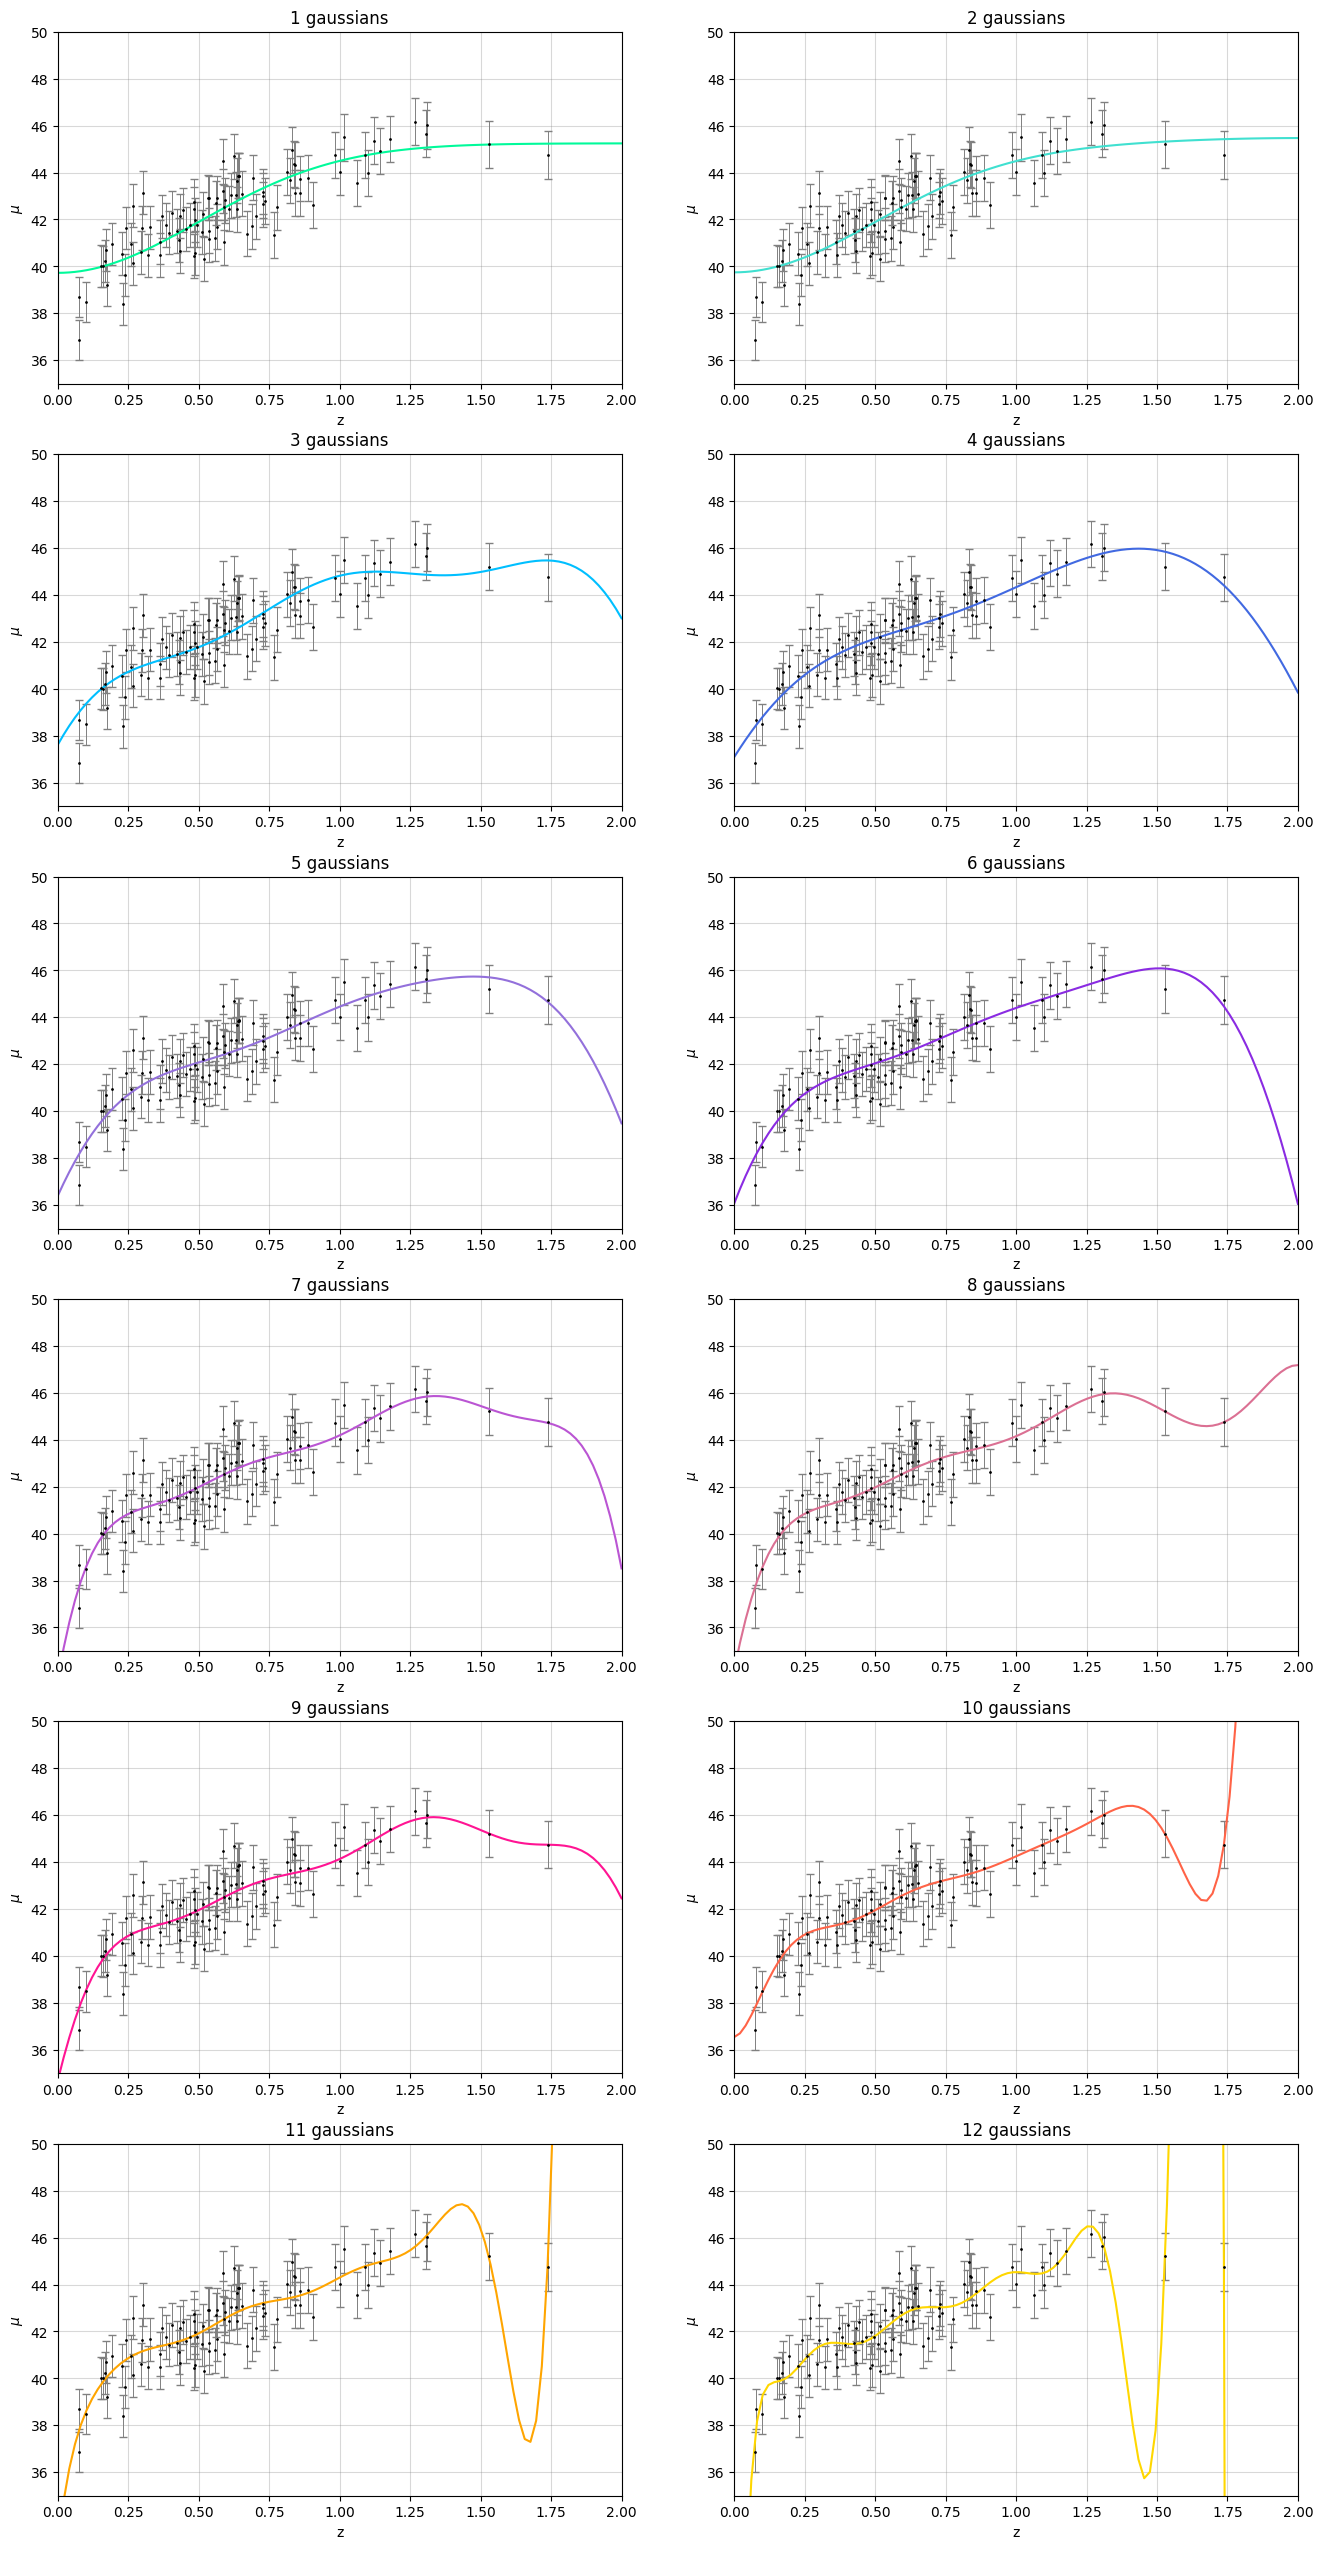

In [8]:
X_points = np.linspace(0, 2.0, 100)
xgrid = X_points[:, np.newaxis]

fig = plt.figure(figsize=(16, 32))

n_gaussians = np.arange(1, 13)
sigma_fix = 0.5

for i, n in enumerate(n_gaussians):
    ax = fig.add_subplot(6,2,1+i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)

    centers_points = np.linspace(0, 2.0, n)     # I want n gaussians -> centering them in a linspace of n points
    centers = centers_points[:, np.newaxis]
    model = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma_fix)
    model.fit(z, mu_sample, dmu)
    y_gauss = model.predict(xgrid)
    
    plt.plot(xgrid, y_gauss, lw = 1.5, color = colors[i])
    plt.xlabel('z')
    plt.ylabel('$\\mu$')
    plt.grid(alpha=0.3, c='gray')
    plt.title('%i gaussians' % n)
    plt.xlim(0,2)
    plt.ylim(35,50)
    
plt.show()

In this case, too, we'll perform a leave-one-out cross-validation:

Number of gaussians: 1 - Train: 0.9481 - test: 0.7611
Number of gaussians: 2 - Train: 0.9474 - test: 0.7712
Number of gaussians: 3 - Train: 0.9272 - test: 0.7804
Number of gaussians: 4 - Train: 0.8715 - test: 0.7407
Number of gaussians: 5 - Train: 0.8677 - test: 0.7398
Number of gaussians: 6 - Train: 0.8660 - test: 0.8484
Number of gaussians: 7 - Train: 0.8488 - test: 0.7440
Number of gaussians: 8 - Train: 0.8483 - test: 0.7223
Number of gaussians: 9 - Train: 0.8481 - test: 1.2244
Number of gaussians: 10 - Train: 0.8466 - test: 1.7035
Number of gaussians: 11 - Train: 0.8458 - test: 21.3649
Number of gaussians: 12 - Train: 0.8242 - test: 20.8026

The best model is the one with 8 gaussians



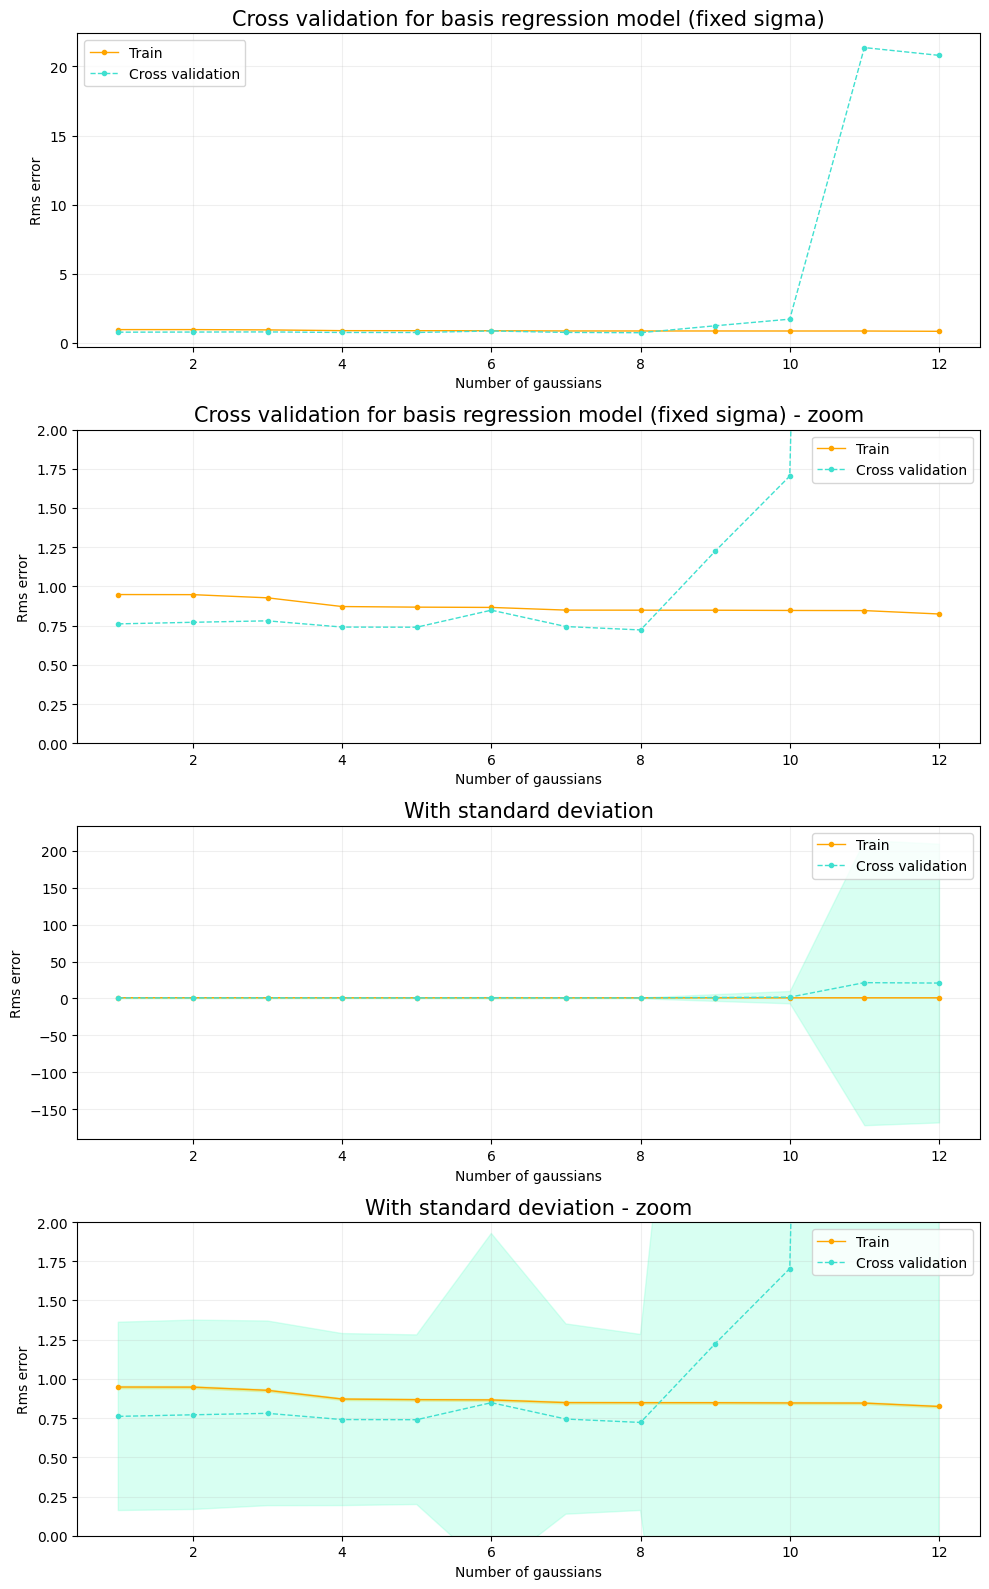

In [34]:
n_splits = 100

rms_train_tot = np.empty(len(n_gaussians))
rms_test_tot = np.empty(len(n_gaussians))

rms_train_tot_std = np.empty(len(n_gaussians))
rms_test_tot_std = np.empty(len(n_gaussians))

for j, n in enumerate(n_gaussians):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=None)     # Splitting the data in train and test
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
        z_train, z_test = z[train_index], z[test_index]
        mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
        dmu_train, dmu_test = dmu[train_index], dmu[test_index]

        centers_points = np.linspace(0, 2.0, n)
        centers = centers_points[:, np.newaxis]
        model = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma_fix)
        model.fit(z_train, mu_train, dmu_train)
        
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))
    
    print('Number of gaussians: %i - Train: %.4f - test: %.4f' % (n, np.mean(rms_train), np.mean(rms_test)))
    rms_train_tot[j] = np.mean(rms_train)
    rms_test_tot[j] = np.mean(rms_test)

    rms_train_tot_std[j] = np.std(rms_train)
    rms_test_tot_std[j] = np.std(rms_test)

n_best_fix = n_gaussians[np.argmin(rms_test_tot)]
print('\nThe best model is the one with %i gaussians\n' % n_best_fix)

fig, ax = plt.subplots(4, 1, figsize=(10, 16))

ax[0].plot(n_gaussians, rms_train_tot, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[0].plot(n_gaussians, rms_test_tot, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[0].set_xlabel('Number of gaussians')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Cross validation for basis regression model (fixed sigma)', fontsize=15)
ax[0].grid(alpha=0.2)
ax[0].legend()

ax[1].plot(n_gaussians, rms_train_tot, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[1].plot(n_gaussians, rms_test_tot, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[1].set_xlabel('Number of gaussians')
ax[1].set_ylabel('Rms error')
ax[1].set_ylim(0, 2)
ax[1].set_title('Cross validation for basis regression model (fixed sigma) - zoom', fontsize=15)
ax[1].grid(alpha=0.2)
ax[1].legend()

ax[2].plot(n_gaussians, rms_train_tot, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[2].plot(n_gaussians, rms_test_tot, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[2].fill_between(n_gaussians, rms_train_tot - rms_train_tot_std, rms_train_tot + rms_train_tot_std, color='gold', alpha=0.3)
ax[2].fill_between(n_gaussians, rms_test_tot - rms_test_tot_std, rms_test_tot + rms_test_tot_std, color='aquamarine', alpha=0.3)
ax[2].set_xlabel('Number of gaussians')
ax[2].set_ylabel('Rms error')
ax[2].set_title('With standard deviation', fontsize=15)
ax[2].grid(alpha=0.2)
ax[2].legend()

ax[3].plot(n_gaussians, rms_train_tot, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[3].plot(n_gaussians, rms_test_tot, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[3].fill_between(n_gaussians, rms_train_tot - rms_train_tot_std, rms_train_tot + rms_train_tot_std, color='gold', alpha=0.3)
ax[3].fill_between(n_gaussians, rms_test_tot - rms_test_tot_std, rms_test_tot + rms_test_tot_std, color='aquamarine', alpha=0.3)
ax[3].set_xlabel('Number of gaussians')
ax[3].set_ylabel('Rms error')
ax[3].set_ylim(0, 2)
ax[3].set_title('With standard deviation - zoom', fontsize=15)
ax[3].grid(alpha=0.2)
ax[3].legend()

plt.tight_layout(w_pad=2.5)
plt.show()

If we instead leave sigma as a free parameter, we can cross-validate both on the centers of the gaussians and their standard deviation:

In [30]:
n_splits = 100

#sigma_try = np.array([0.5])
sigma_try = np.linspace(0.1, 1, 20)

# Matrix: 
# sigma1, n1     sigma1, n2     ...
# sigma2, n1     sigma2, n2     ...
#    ...            ...         ...

rms_test_matrix = np.empty((len(sigma_try), len(n_gaussians)))

for k, sigma in enumerate(sigma_try):
    for j, n in enumerate(n_gaussians):

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=None)
    
        rms_test = np.empty(n_splits)     # I won't keep track of the rms_train this time, there's no plot

        for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
            z_train, z_test = z[train_index], z[test_index]
            mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
            dmu_train, dmu_test = dmu[train_index], dmu[test_index]
    
            centers_points = np.linspace(0, 2.0, n)
            centers = centers_points[:, np.newaxis]
            model = BasisFunctionRegression('gaussian', mu=centers, sigma=sigma)
            model.fit(z_train, mu_train, dmu_train)

            rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))

        rms_test_matrix[k, j] = np.mean(rms_test)

print(rms_test_matrix)

[[1.20477948e+00 5.65949302e+01 6.31089926e+01 5.14896576e+01
  4.48329647e+02 1.67672687e+03 1.41206647e+04 3.77885049e+04
  7.76708810e+04 1.31708904e+05 6.86597120e+05 1.88923139e+06]
 [1.12121377e+00 1.90416277e+00 1.88135256e+00 1.22860209e+00
  2.64176938e+00 2.80973274e+00 3.92629298e+00 8.54434406e+00
  1.77977664e+01 8.56974700e+01 1.01277824e+02 7.76831739e+02]
 [1.02814269e+00 1.17246200e+00 1.07193695e+00 7.97538583e-01
  9.07782318e-01 9.27945174e-01 7.08102045e-01 9.19176785e-01
  1.18439238e+00 1.09835708e+01 4.79643173e+00 6.93159494e+01]
 [9.55805899e-01 1.01925895e+00 9.55205614e-01 7.56738280e-01
  7.97130031e-01 8.41701585e-01 7.38769258e-01 7.87128386e-01
  9.50684586e-01 5.16255345e+00 7.19142592e+00 3.71543976e+01]
 [8.90925996e-01 9.30046727e-01 9.01253631e-01 7.43121866e-01
  7.63380546e-01 8.17597540e-01 7.26258242e-01 8.06217918e-01
  1.07368360e+00 3.66315866e+00 9.45067379e+00 3.10984143e+01]
 [8.38477872e-01 8.54946693e-01 8.57627254e-01 7.37188715e-01
  7

In [31]:
min_index_flat = np.argmin(rms_test_matrix)
    
min_index_2d = np.unravel_index(min_index_flat, rms_test_matrix.shape)

n_best = n_gaussians[min_index_2d[1]]
sigma_best = sigma_try[min_index_2d[0]]

print(min_index_2d)
print('Best number of gaussians: %i' % n_best)
print('Best sigma: %0.2f' % sigma_best)

(2, 6)
Best number of gaussians: 7
Best sigma: 0.19


We can confront this model with the fixed sigma one:

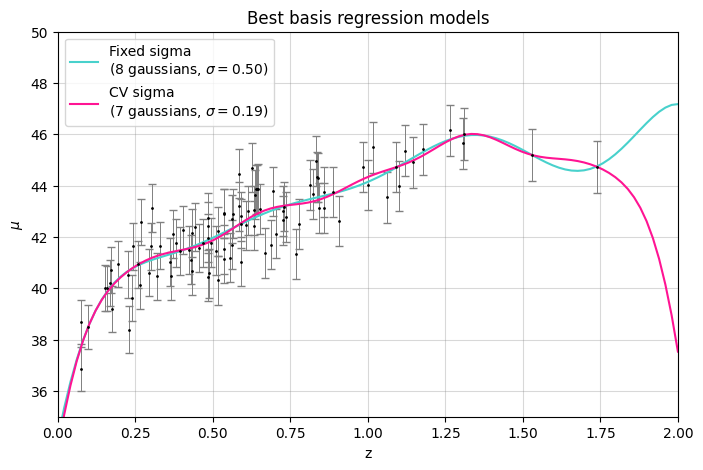

In [32]:
# Best model for fixed sigma: n = 8, sigma = 0.5
centers_points_fix = np.linspace(0, 2.0, n_best_fix)
centers_fix = centers_points_fix[:, np.newaxis]

model_fix = BasisFunctionRegression('gaussian', mu = centers_fix, sigma = sigma_fix)
model_fix.fit(z, mu_sample, dmu)
y_fix = model_fix.predict(xgrid)

# Best model for cross-validated sigma: n = 4, sigma = 1.00
centers_points_cv = np.linspace(0, 2.0, n_best)
centers_cv = centers_points_cv[:, np.newaxis]

model_cv = BasisFunctionRegression('gaussian', mu = centers_cv, sigma = sigma_best)
model_cv.fit(z, mu_sample, dmu)
y_cv = model_cv.predict(xgrid)
                                      
# Plotting
plt.figure(figsize=(8, 5))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)

plt.plot(xgrid, y_fix, lw = 1.5, color = 'mediumturquoise', label = 'Fixed sigma\n(%i gaussians, $\\sigma=$%0.2f)' % (n_best_fix, sigma_fix))
plt.plot(xgrid, y_cv, lw = 1.5, color = 'deeppink', label = 'CV sigma\n(%i gaussians, $\\sigma=$%0.2f)' % (n_best, sigma_best))
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.grid(alpha=0.3, c='gray')
plt.title('Best basis regression models')
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc = 'upper left')
plt.show()

The two models are fairly similar in the first part of the plot, where there are numerous data points guiding the fit. For $z\gtrsim1.25$, instead, the models behave differently: the 7-gaussians one follows the lower points, while the 8-gaussians one passes through them and then rises again.

This is the learning curve for the model that has been cross-validated both on n_gaussians and sigma:

In [33]:
dataset_size = np.array(np.arange(5, 101, 5))
np.random.seed(123)

rms_train_lc = np.empty(len(dataset_size))
rms_test_lc= np.empty(len(dataset_size)) 

rms_train_lc_std = np.empty(len(dataset_size))
rms_test_lc_std = np.empty(len(dataset_size))

for index, ds in enumerate(dataset_size):
    
    data_indexes = np.random.choice(np.arange(0, 100), size=ds, replace=False)
    z_lc = z[data_indexes]
    mu_sample_lc = mu_sample[data_indexes]
    dmu_lc = dmu[data_indexes]
    
    n_splits = ds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=None) 
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z_lc), np.arange(n_splits)):
        
        z_train, z_test = z_lc[train_index], z_lc[test_index]
        mu_train, mu_test = mu_sample_lc[train_index], mu_sample_lc[test_index]
        dmu_train, dmu_test = dmu_lc[train_index], dmu_lc[test_index]

        centers_points_cv = np.linspace(0, 2.0, n_best)
        centers_cv = centers_points_cv[:, np.newaxis]
        
        model = BasisFunctionRegression('gaussian', mu = centers_cv, sigma = sigma_best)
        model.fit(z_train, mu_train, dmu_train)
    
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))

    rms_train_lc[index] = np.mean(rms_train)
    rms_test_lc[index] = np.mean(rms_test)

    rms_train_lc_std[index] = np.std(rms_train)
    rms_test_lc_std[index] = np.std(rms_test)

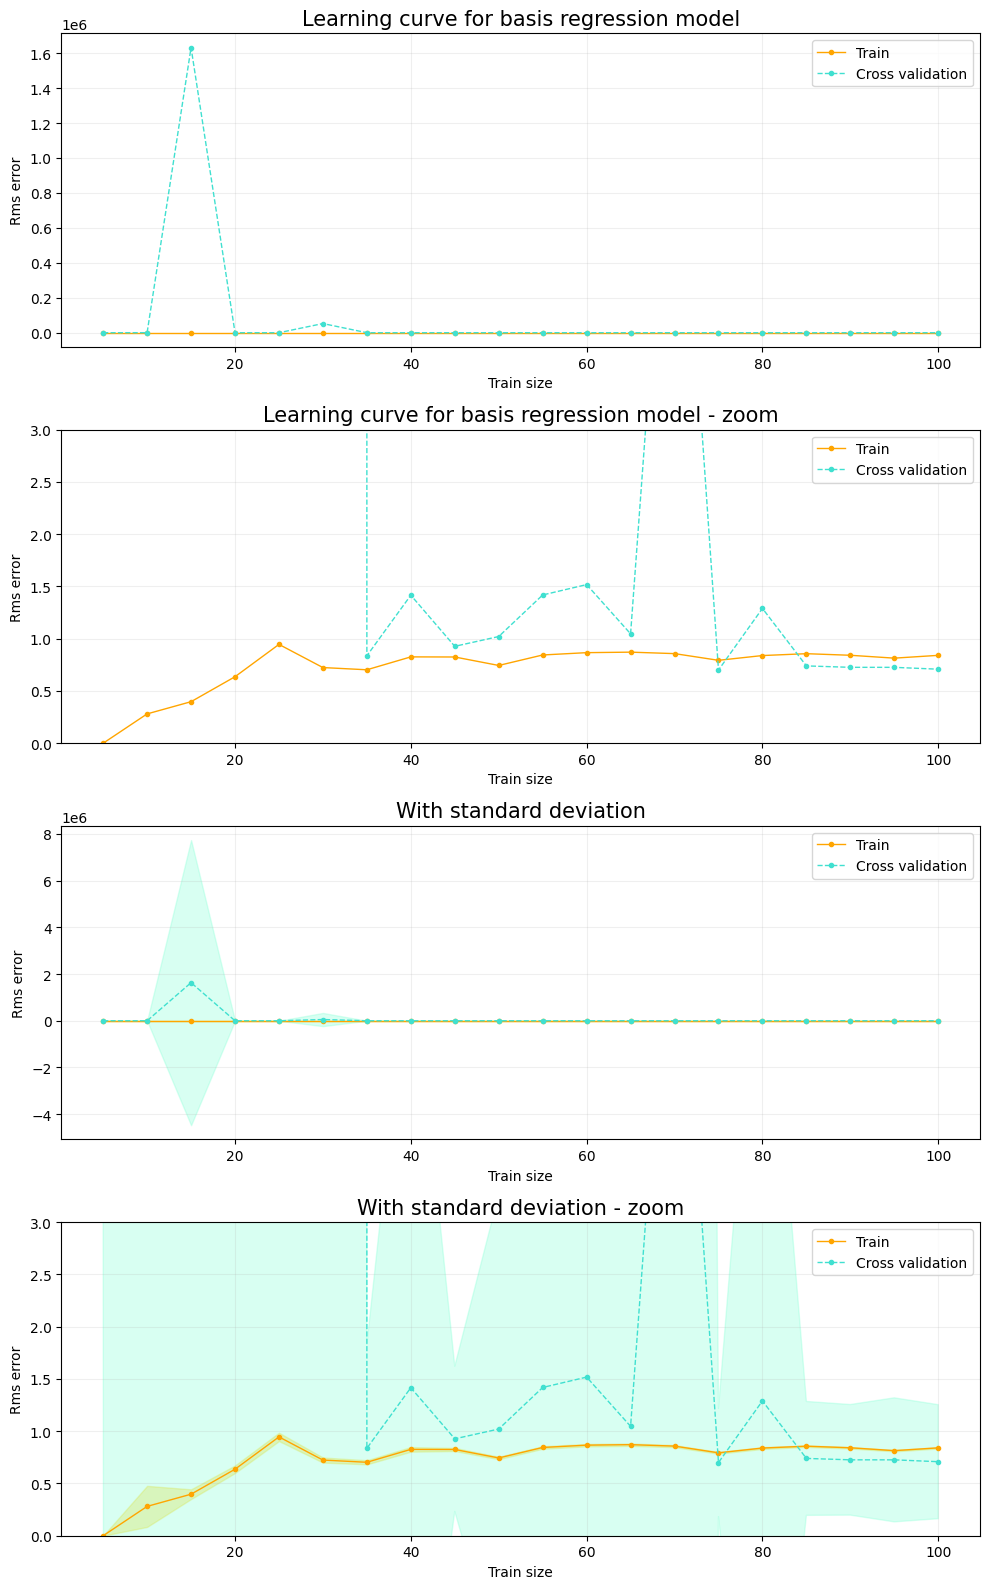

In [35]:
fig, ax = plt.subplots(4, 1, figsize=(10, 16))

ax[0].plot(dataset_size, rms_train_lc, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[0].plot(dataset_size, rms_test_lc, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[0].set_xlabel('Train size')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Learning curve for basis regression model', fontsize=15)
ax[0].grid(alpha=0.2)
ax[0].legend()

ax[1].plot(dataset_size, rms_train_lc, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[1].plot(dataset_size, rms_test_lc, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[1].set_xlabel('Train size')
ax[1].set_ylabel('Rms error')
ax[1].set_ylim(0, 3)
ax[1].set_title('Learning curve for basis regression model - zoom', fontsize=15)
ax[1].grid(alpha=0.2)
ax[1].legend()

ax[2].plot(dataset_size, rms_train_lc, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[2].plot(dataset_size, rms_test_lc, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[2].fill_between(dataset_size, rms_train_lc - rms_train_lc_std, rms_train_lc + rms_train_lc_std, color='gold', alpha=0.3)
ax[2].fill_between(dataset_size, rms_test_lc - rms_test_lc_std, rms_test_lc + rms_test_lc_std, color='aquamarine', alpha=0.3)
ax[2].set_xlabel('Train size')
ax[2].set_ylabel('Rms error')
ax[2].set_title('With standard deviation', fontsize=15)
ax[2].grid(alpha=0.2)
ax[2].legend()

ax[3].plot(dataset_size, rms_train_lc, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[3].plot(dataset_size, rms_test_lc, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[3].fill_between(dataset_size, rms_train_lc - rms_train_lc_std, rms_train_lc + rms_train_lc_std, color='gold', alpha=0.3)
ax[3].fill_between(dataset_size, rms_test_lc - rms_test_lc_std, rms_test_lc + rms_test_lc_std, color='aquamarine', alpha=0.3)
ax[3].set_xlabel('Train size')
ax[3].set_ylabel('Rms error')
ax[3].set_ylim(0, 3)
ax[3].set_title('With standard deviation - zoom', fontsize=15)
ax[3].grid(alpha=0.2)
ax[3].legend()

plt.tight_layout(w_pad=2.5)
plt.show()

In this case, we need more data than the polynomial case to to achieve a better fit for the model, but it still seems that the dataset is large enough. To be sure, though, this is a case in which I'd want more datapoints, particularly for high $z$ values (where the gaussian models diverge).

## Kernel regression

We use now the Nadaraya-Watson regression, in which the only parameter to cross-validate is the bandwidth of the kernels:

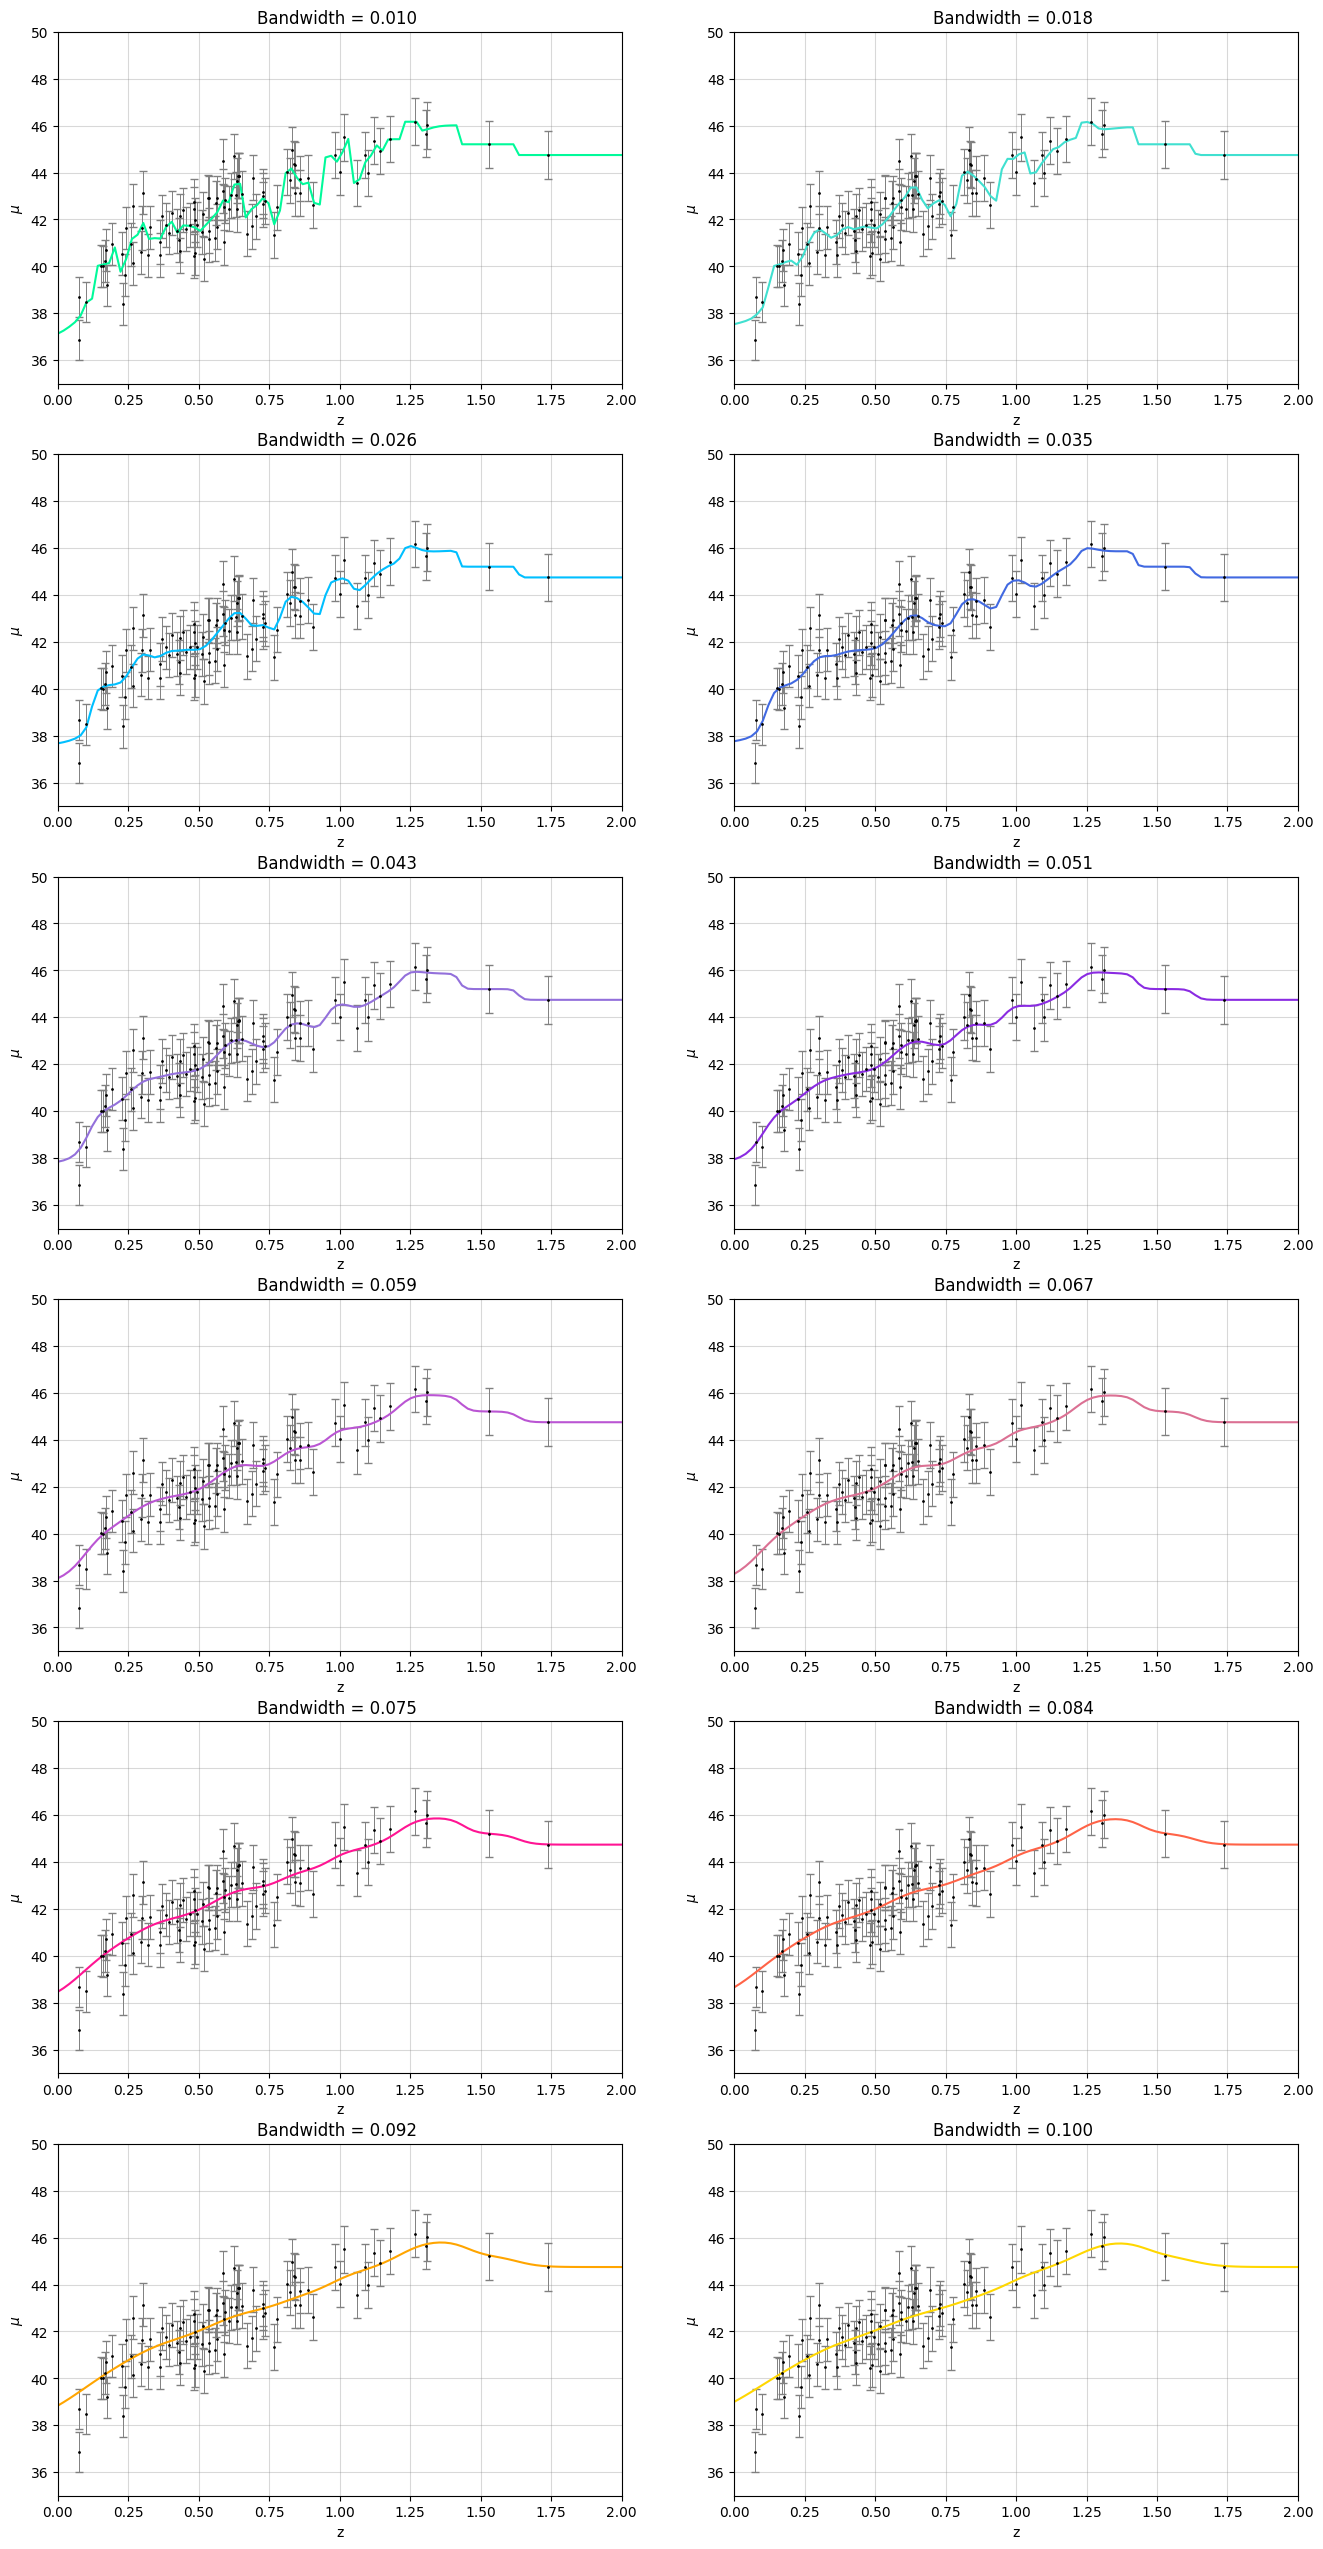

In [15]:
bandwidth = np.linspace(0.01, 0.1, 12)

fig = plt.figure(figsize=(16, 32))

for i, bw in enumerate(bandwidth):
    ax = fig.add_subplot(6,2,1+i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)

    model = NadarayaWatson(kernel='gaussian', h=bw)
    model.fit(z, mu_sample)
    y_kernel = model.predict(xgrid)
    
    plt.plot(xgrid, y_kernel, lw = 1.5, color = colors[i])
    plt.xlabel('z')
    plt.ylabel('$\\mu$')
    plt.grid(alpha=0.3, c='gray')
    plt.title('Bandwidth = %0.3f ' % bw)
    plt.xlim(0,2)
    plt.ylim(35,50)
    
plt.show()

Cross-validating on the bandwidths:

Bandwidth: 0.010 - Train: 0.6544 - Test: 0.8422
Bandwidth: 0.018 - Train: 0.7142 - Test: 0.7622
Bandwidth: 0.026 - Train: 0.7463 - Test: 0.7287
Bandwidth: 0.035 - Train: 0.7713 - Test: 0.7108
Bandwidth: 0.043 - Train: 0.7930 - Test: 0.7055
Bandwidth: 0.051 - Train: 0.8132 - Test: 0.7082
Bandwidth: 0.059 - Train: 0.8319 - Test: 0.7161
Bandwidth: 0.067 - Train: 0.8486 - Test: 0.7233
Bandwidth: 0.075 - Train: 0.8634 - Test: 0.7294
Bandwidth: 0.084 - Train: 0.8763 - Test: 0.7347
Bandwidth: 0.092 - Train: 0.8879 - Test: 0.7402
Bandwidth: 0.100 - Train: 0.8985 - Test: 0.7455

The best model is the one with bandwidth = 0.043



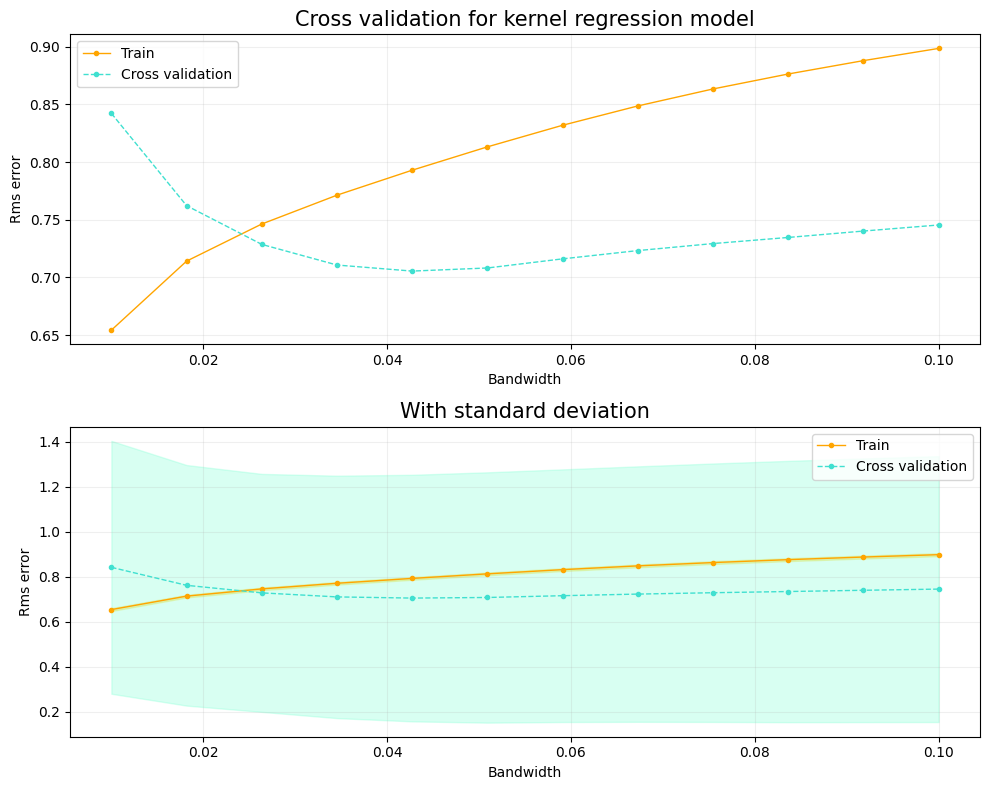

In [39]:
bandwidth = np.linspace(0.01, 0.1, 12)
n_splits = 100

rms_train_tot = np.empty(len(bandwidth))
rms_test_tot = np.empty(len(bandwidth))

rms_train_tot_std = np.empty(len(bandwidth))
rms_test_tot_std = np.empty(len(bandwidth))

for j, bw in enumerate(bandwidth):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)     # Splitting the data in train and test
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
        z_train, z_test = z[train_index], z[test_index]
        mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
        dmu_train, dmu_test = dmu[train_index], dmu[test_index]
    
        model = NadarayaWatson(kernel='gaussian', h=bw)
        model.fit(z_train, mu_train)
        
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))
    
    print('Bandwidth: %.3f - Train: %.4f - Test: %.4f' % (bw, np.mean(rms_train), np.mean(rms_test)))
    rms_train_tot[j] = np.mean(rms_train)
    rms_test_tot[j] = np.mean(rms_test)

    rms_train_tot_std[j] = np.std(rms_train)
    rms_test_tot_std[j] = np.std(rms_test)

bw_best = bandwidth[np.argmin(rms_test_tot)]
print('\nThe best model is the one with bandwidth = %.3f\n' % bw_best)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(bandwidth, rms_train_tot, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[0].plot(bandwidth, rms_test_tot, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[0].set_xlabel('Bandwidth')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Cross validation for kernel regression model', fontsize=15)
ax[0].grid(alpha=0.2)
ax[0].legend()

ax[1].plot(bandwidth, rms_train_tot, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[1].plot(bandwidth, rms_test_tot, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[1].fill_between(bandwidth, rms_train_tot - rms_train_tot_std, rms_train_tot + rms_train_tot_std, color='gold', alpha=0.3)
ax[1].fill_between(bandwidth, rms_test_tot - rms_test_tot_std, rms_test_tot + rms_test_tot_std, color='aquamarine', alpha=0.3)
ax[1].set_xlabel('Bandwidth')
ax[1].set_ylabel('Rms error')
ax[1].set_title('With standard deviation', fontsize=15)
ax[1].grid(alpha=0.2)
ax[1].legend()

plt.tight_layout(w_pad=2.5)
plt.show()

In [41]:
np.random.seed(123)

rms_train_lc = np.empty(len(dataset_size))
rms_test_lc= np.empty(len(dataset_size)) 

rms_train_lc_std = np.empty(len(dataset_size))
rms_test_lc_std = np.empty(len(dataset_size)) 

for index, ds in enumerate(dataset_size):
    
    data_indexes = np.random.choice(np.arange(0, 100), size=ds, replace=False)
    z_lc = z[data_indexes]
    mu_sample_lc = mu_sample[data_indexes]
    dmu_lc = dmu[data_indexes]
    
    n_splits = ds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=None) 
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z_lc), np.arange(n_splits)):
        
        z_train, z_test = z_lc[train_index], z_lc[test_index]
        mu_train, mu_test = mu_sample_lc[train_index], mu_sample_lc[test_index]
        dmu_train, dmu_test = dmu_lc[train_index], dmu_lc[test_index]

        model = NadarayaWatson(kernel='gaussian', h=bw_best)
        model.fit(z_train, mu_train, dmu_train)
    
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))

    rms_train_lc[index] = np.mean(rms_train)
    rms_test_lc[index] = np.mean(rms_test)

    rms_train_lc_std[index] = np.std(rms_train)
    rms_test_lc_std[index] = np.std(rms_test)

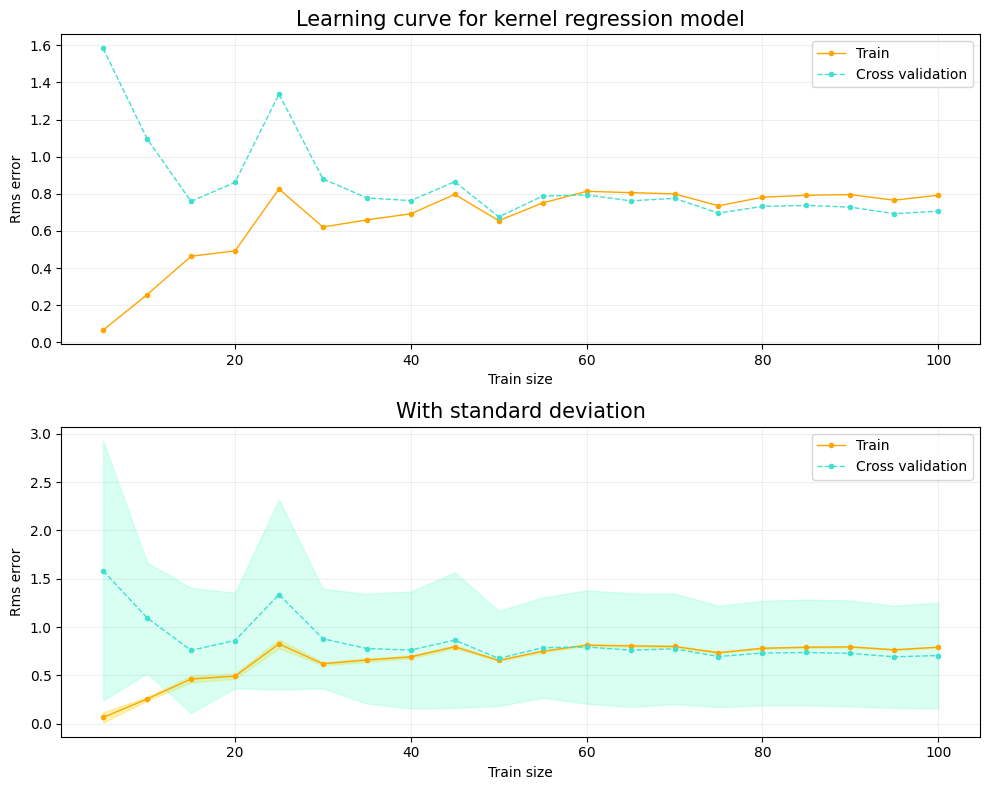

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(dataset_size, rms_train_lc, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[0].plot(dataset_size, rms_test_lc, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[0].set_xlabel('Train size')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Learning curve for kernel regression model', fontsize=15)
ax[0].grid(alpha=0.2)
ax[0].legend()

ax[1].plot(dataset_size, rms_train_lc, lw=1, color='orange', ls='-', marker='o', markersize=3, label='Train')
ax[1].plot(dataset_size, rms_test_lc, lw=1, color='turquoise', ls='--', marker='o', markersize=3, label='Cross validation')
ax[1].fill_between(dataset_size, rms_train_lc - rms_train_lc_std, rms_train_lc + rms_train_lc_std, color='gold', alpha=0.3)
ax[1].fill_between(dataset_size, rms_test_lc - rms_test_lc_std, rms_test_lc + rms_test_lc_std, color='aquamarine', alpha=0.3)
ax[1].set_xlabel('Train size')
ax[1].set_ylabel('Rms error')
ax[1].set_title('With standard deviation', fontsize=15)
ax[1].grid(alpha=0.2)
ax[1].legend()

plt.tight_layout(w_pad=2.5)
plt.show()


In this case, the model fitting results converge starting from a dataset of $\sim30$ elements.

## Summary

Let's plot together all the best models:

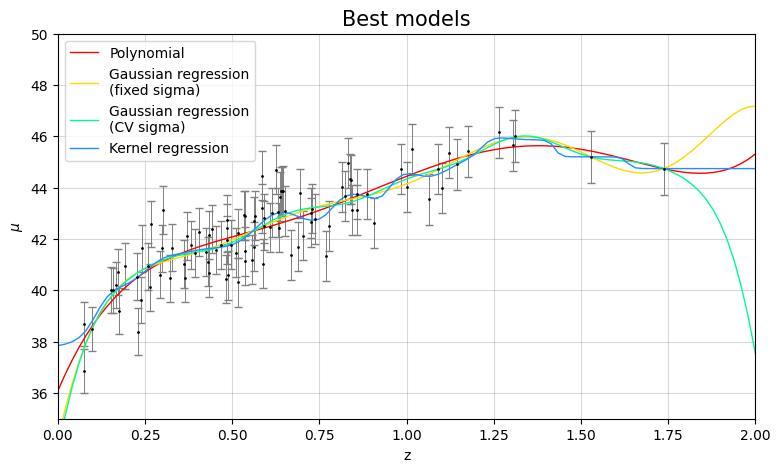

In [19]:
# Polynomial model
model_poly = PolynomialRegression(d_best)
model_poly.fit(z, mu_sample, dmu)
y_poly = model_poly.predict(xgrid)

#-----------------------------------------------------------------------------------
# Gaussian regression model, fixed sigma
centers_points_fix = np.linspace(0, 2.0, n_best_fix)
centers_fix = centers_points_fix[:, np.newaxis]

model_fix = BasisFunctionRegression('gaussian', mu = centers_fix, sigma = sigma_fix)
model_fix.fit(z, mu_sample, dmu)
y_fix = model_fix.predict(xgrid)

#-----------------------------------------------------------------------------------
# Gaussian regression model, cross-validated sigma
centers_points_cv = np.linspace(0, 2.0, n_best)
centers_cv = centers_points_cv[:, np.newaxis]

model_cv = BasisFunctionRegression('gaussian', mu = centers_cv, sigma = sigma_best)
model_cv.fit(z, mu_sample, dmu)
y_cv = model_cv.predict(xgrid)

#-----------------------------------------------------------------------------------
# Kernel regression model
model_ker = NadarayaWatson(kernel='gaussian', h=bw_best)
model_ker.fit(z, mu_sample)
y_ker = model_ker.predict(xgrid)

#-----------------------------------------------------------------------------------
# Plotting
plt.figure(figsize=(9, 5))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)

plt.plot(xgrid, y_poly, lw = 1, color = 'red', label = 'Polynomial')
plt.plot(xgrid, y_fix, lw = 1, color = 'gold', label = 'Gaussian regression\n(fixed sigma)')
plt.plot(xgrid, y_cv, lw = 1, color = 'mediumspringgreen', label = 'Gaussian regression\n(CV sigma)')
plt.plot(xgrid, y_ker, lw = 1, color = 'dodgerblue', label = 'Kernel regression')

plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.grid(alpha=0.3, c='gray')
plt.title('Best models', fontsize = 15)
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc = 'upper left')
plt.show()


Some comments:

- The polynomial and both gaussian models behave similarly for $z\lesssim1.25$, while the kernel regression model seems to be overfitting the data;
- For $z\gtrsim 1.25$, all models fit the last datapoints fairly well, but then each model behaves in a different way. The last points have a great influence on the fit.

The average rms error on the test set for these models are:

- Polynomial: 0.7270
- Gaussian regression (fixed sigma): 0.7223
- Gaussian regression (CV sigma): 0.7081
- Kernel regression: 0.7055

So, out of the four models, it seems that the Kernel regression one is the best.

In a purely data-driven context, these are the best models, but I suspect that in all of them there's some grade of overfitting (the worst case being the kernel regression model).